# Tobig's 정규세션 10주차 음성 과제 1

- 다음 5개의 질문에 **단답형**으로 답해주세요.

## Q1. 시간에 따른 소리의 진폭을 나타낸 그래프를 영어로 무엇이라고 하나요?

A1. Waveform

## Q2. 샘플링 주파수는 원래 신호의 최고 주파수의 2배 이상이 되어야 원래 신호로 복구할 수 있다는 정리의 이름을 영어로 무엇이라고 하나요?

A2. Nyquist-Shannon Sampling Theorem

## Q3. 소리를 시각화한 것으로, 단시간 푸리에 변환을 통해 시간, 주파수, 진폭 정보를 모두 담고 있는 것을 영어로 무엇이라고 하나요?

A3. Spectrogram

## Q4. 인간의 청각 시스템에 맞게 Mel-scale을 적용하여 주파수를 조절한 스펙트로그램을 영어로 무엇이라고 하나요?

A4. Mel-Spectrogram

## Q5. Speech 정규세션 강의자가 수업 시작할 때 5명을 랜덤으로 지목하여 질문하겠다고 했으나, 실제로는 그보다 적은 n명에게 질문하였습니다. n의 값은 무엇입니까?

A5. 0

# Tobig's 정규세션 10주차 음성 과제 2

1. train 폴더 내의 2,000개 음원을 이용하여 음성 분류 모델을 만들어보세요.
2. 음성 분류 모델을 이용하여 test 폴더 내의 300개 음원을 분류하세요.

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import models
import torchaudio

from glob import glob
import random
import os
from tqdm import tqdm

import librosa
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torchsummary import summary
from sklearn.metrics import accuracy_score

In [2]:
config = {
    'epochs':15,
    'lr': 1e-4,
    'batch_size': 64,
    'val_ratio': 0.1,
    'seed': 42,
    'device':torch.device('cuda' if torch.cuda.is_available() else 'cpu')
}


In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(config['seed'])

In [25]:
label = [int(path.split('/')[-1].split('.')[0][-1]) for path in glob('./train/*')]
label


[0,
 2,
 3,
 8,
 3,
 2,
 2,
 8,
 8,
 1,
 5,
 6,
 0,
 5,
 2,
 6,
 6,
 9,
 2,
 4,
 0,
 2,
 8,
 4,
 4,
 8,
 2,
 5,
 7,
 2,
 0,
 6,
 7,
 7,
 8,
 3,
 4,
 3,
 0,
 8,
 3,
 9,
 1,
 2,
 0,
 1,
 0,
 5,
 0,
 7,
 0,
 3,
 5,
 2,
 9,
 9,
 5,
 9,
 9,
 7,
 1,
 8,
 2,
 9,
 9,
 2,
 1,
 7,
 8,
 7,
 1,
 2,
 0,
 4,
 1,
 9,
 1,
 9,
 9,
 1,
 7,
 4,
 7,
 6,
 8,
 5,
 4,
 7,
 3,
 8,
 4,
 6,
 9,
 7,
 7,
 1,
 7,
 3,
 2,
 7,
 6,
 7,
 1,
 8,
 9,
 0,
 3,
 1,
 2,
 3,
 5,
 0,
 6,
 2,
 5,
 8,
 2,
 6,
 1,
 3,
 3,
 8,
 3,
 8,
 2,
 8,
 8,
 5,
 8,
 3,
 0,
 4,
 9,
 4,
 4,
 0,
 8,
 4,
 7,
 8,
 3,
 1,
 4,
 4,
 7,
 4,
 1,
 7,
 3,
 4,
 6,
 9,
 6,
 6,
 1,
 6,
 8,
 6,
 3,
 6,
 4,
 6,
 9,
 3,
 3,
 8,
 5,
 6,
 1,
 5,
 7,
 5,
 0,
 6,
 5,
 4,
 9,
 9,
 8,
 1,
 2,
 0,
 1,
 4,
 4,
 4,
 0,
 6,
 9,
 7,
 3,
 4,
 7,
 4,
 5,
 2,
 8,
 3,
 4,
 8,
 1,
 0,
 2,
 6,
 3,
 4,
 6,
 5,
 0,
 8,
 6,
 5,
 2,
 3,
 7,
 7,
 6,
 9,
 3,
 6,
 2,
 9,
 4,
 7,
 6,
 1,
 4,
 2,
 1,
 3,
 7,
 7,
 8,
 0,
 7,
 1,
 9,
 4,
 1,
 6,
 6,
 8,
 0,
 3,
 0,
 3,
 5,
 4,
 1,
 6,


In [26]:

train_path_list,val_path_list = train_test_split(glob('./train/*'),test_size=config['val_ratio'],random_state=config['seed'], shuffle=True,stratify=label)
test_path_list = sorted(glob('./test/*'), key=lambda x: int(x.split('/')[-1].split('.')[0]))
test_path_list[:10]

['./test/0000.wav',
 './test/0001.wav',
 './test/0002.wav',
 './test/0003.wav',
 './test/0004.wav',
 './test/0005.wav',
 './test/0006.wav',
 './test/0007.wav',
 './test/0008.wav',
 './test/0009.wav']

In [27]:
class AudioDataset(Dataset):
    def __init__(self, path_list, is_train = True,use_specto = True,pad = 50000):
        
        self.path_list = path_list
        self.is_train = is_train
        self.use_specto = use_specto
        self.pad = pad
        self.transform = torchaudio.transforms.MelSpectrogram(n_mels=64)

    def __len__(self):
        return len(self.path_list)
    
    def __getitem__(self, idx):
        ret = {}

        path = self.path_list[idx]
        data,sr = torchaudio.load(path)[0]
        if self.pad > len(data):
            padding = self.pad - len(data)        
            data = F.pad(data,(0,padding),'constant',0)
        else:
            data = data[:self.pad]

        if self.use_specto:
            data = self.transform(data)

        ret['X'] = data

        if self.is_train:
            label = int(path.split('/')[-1].split('.')[0][-1])
            ret['y'] = label

        return ret  
    
train_dataset = AudioDataset(train_path_list,is_train = True,use_specto = True)
train_loader = DataLoader(train_dataset,batch_size=config['batch_size'],shuffle=True,num_workers=4)

val_dataset = AudioDataset(val_path_list,is_train=True,use_specto=True)
val_loader = DataLoader(val_dataset,batch_size=config['batch_size'],shuffle=False,num_workers=4)

test_dataset = AudioDataset(test_path_list,is_train=False,use_specto=True)
test_loader = DataLoader(test_dataset,batch_size=config['batch_size'],shuffle=False,num_workers=4)   

torch.Size([64, 251])


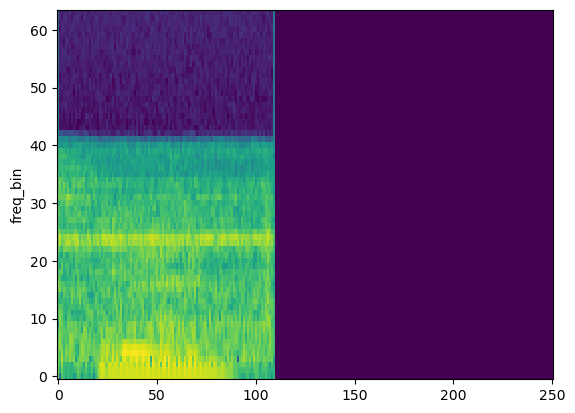

In [28]:
def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")

plot_spectrogram(next(iter(train_loader))['X'][10].numpy())
print(next(iter(train_loader))['X'][10].size())

In [29]:

class Trainer():
    def __init__(self,model,config):

        self.config = config
        self.model = model.to(self.config['device'])
        self.optimizer = torch.optim.AdamW(model.parameters(),config['lr'],weight_decay=0.2)
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer,mode='min',patience=3,verbose=True)

        self.criterion = nn.CrossEntropyLoss()
        self.epoch = 0

        self.loss_dict = {}

    def train(self,train_loader,val_loader):

        for epoch in range(self.config['epochs']):
            self.model.train()
            for step,data in enumerate(tqdm(train_loader)):
                
                
                y = data['y']
                y = y.type(torch.LongTensor).to(self.config['device'])
                X = data['X'].to(self.config['device']).float()

                outputs = self.model(X)

                loss = self.criterion(outputs,y)

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

            val_loss,val_acc = self.validation(val_loader)
            self.scheduler.step(val_loss)
            self.epoch += 1

            print(f'Epoch: {self.epoch} Val Loss: {val_loss} Val Acc: {val_acc}')

    def validation(self,val_loader):

        sum_loss = []
        logit = []
        gt = []
        self.model.eval()
        for step,data in enumerate(val_loader):

            with torch.no_grad():
                y = data['y']
                y = y.type(torch.LongTensor).to(self.config['device'])
                X = data['X'].to(self.config['device']).float()

                outputs = self.model(X)

                loss = self.criterion(outputs,y)
                sum_loss.append(loss.item())

                logit.extend(outputs.argmax(1).detach().cpu().numpy())

                gt.extend(y.detach().cpu().numpy())
        logit = np.array(logit)
        gt = np.array(gt)
        accuracy = accuracy_score(gt,logit)
        sum_loss = np.mean(sum_loss)
        return sum_loss,accuracy
    
    def test(self,test_loader):

        logit = torch.FloatTensor().to(self.config['device'])
        self.model.eval()
        for step,data in enumerate(tqdm(test_loader)):

            with torch.no_grad():
                
                X = data['X'].to(self.config['device']).float()

                outputs = self.model(X)
                logit = torch.cat((outputs,logit),dim=0)

        result = torch.argmax(logit,dim=1)
        return result,logit



In [30]:
# Using Waveform encoder
class WaveAudioClassifier(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv1d(1,32,kernel_size=64,stride=16)
        self.bn1 = nn.BatchNorm1d(32)

        self.conv2 = nn.Conv1d(32,64,kernel_size=3)
        self.bn2 = nn.BatchNorm1d(64)
        self.pool2 = nn.MaxPool1d(4)

        self.conv3 = nn.Conv1d(64,128,kernel_size=3)
        self.bn3 = nn.BatchNorm1d(128)

        self.conv4 = nn.Conv1d(128,256,kernel_size=3)
        self.bn4 = nn.BatchNorm1d(256)

        self.conv5 = nn.Conv1d(256,512,kernel_size=3)
        self.bn5 = nn.BatchNorm1d(512)

        self.linear = nn.Linear(512,10)

    def forward(self,x):
        x = x.unsqueeze(1)
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))

        x = F.avg_pool1d(x,kernel_size=x.size()[-1])
        x = x.squeeze(2)
        x = self.linear(x)

        return x

In [31]:
train_dataset = AudioDataset(train_path_list,is_train = True,use_specto = False,pad=100000)
train_loader = DataLoader(train_dataset,batch_size=config['batch_size'],shuffle=True,num_workers=4)

val_dataset = AudioDataset(val_path_list,is_train=True,use_specto=False,pad=100000)
val_loader = DataLoader(val_dataset,batch_size=config['batch_size'],shuffle=False,num_workers=4)

test_dataset = AudioDataset(test_path_list,is_train=False,use_specto=False,pad=100000)
test_loader = DataLoader(test_dataset,batch_size=config['batch_size'],shuffle=False,num_workers=4)     

In [36]:
config = {
    'epochs':100,
    'lr': 1e-4,
    'batch_size': 64,
    'val_ratio': 0.1,
    'seed': 42,
    'device':torch.device('cuda' if torch.cuda.is_available() else 'cpu')
}


In [37]:
model = WaveAudioClassifier()
trainer = Trainer(model,config)
trainer.train(train_loader,val_loader)

  0%|          | 0/29 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:01<00:00, 22.02it/s]


Epoch: 1 Val Loss: 2.29801481962204 Val Acc: 0.105


100%|██████████| 29/29 [00:01<00:00, 22.80it/s]


Epoch: 2 Val Loss: 2.2023375034332275 Val Acc: 0.225


100%|██████████| 29/29 [00:01<00:00, 22.69it/s]


Epoch: 3 Val Loss: 2.027446359395981 Val Acc: 0.28


100%|██████████| 29/29 [00:01<00:00, 22.36it/s]


Epoch: 4 Val Loss: 1.9554592967033386 Val Acc: 0.395


100%|██████████| 29/29 [00:01<00:00, 22.88it/s]


Epoch: 5 Val Loss: 1.8481110334396362 Val Acc: 0.4


100%|██████████| 29/29 [00:01<00:00, 22.40it/s]


Epoch: 6 Val Loss: 1.7813482284545898 Val Acc: 0.475


100%|██████████| 29/29 [00:01<00:00, 22.05it/s]


Epoch: 7 Val Loss: 1.7354858219623566 Val Acc: 0.515


100%|██████████| 29/29 [00:01<00:00, 22.65it/s]


Epoch: 8 Val Loss: 1.6648514568805695 Val Acc: 0.51


100%|██████████| 29/29 [00:01<00:00, 22.96it/s]


Epoch: 9 Val Loss: 1.675126701593399 Val Acc: 0.425


100%|██████████| 29/29 [00:01<00:00, 22.88it/s]


Epoch: 10 Val Loss: 1.69329372048378 Val Acc: 0.415


100%|██████████| 29/29 [00:01<00:00, 22.59it/s]


Epoch: 11 Val Loss: 1.5948402285575867 Val Acc: 0.465


100%|██████████| 29/29 [00:01<00:00, 22.87it/s]


Epoch: 12 Val Loss: 1.529091626405716 Val Acc: 0.53


100%|██████████| 29/29 [00:01<00:00, 22.77it/s]


Epoch: 13 Val Loss: 1.5374338924884796 Val Acc: 0.5


100%|██████████| 29/29 [00:01<00:00, 22.71it/s]


Epoch: 14 Val Loss: 1.4641112089157104 Val Acc: 0.635


100%|██████████| 29/29 [00:01<00:00, 22.53it/s]


Epoch: 15 Val Loss: 1.4285743534564972 Val Acc: 0.6


100%|██████████| 29/29 [00:01<00:00, 22.72it/s]


Epoch: 16 Val Loss: 1.3887084424495697 Val Acc: 0.7


100%|██████████| 29/29 [00:01<00:00, 22.49it/s]


Epoch: 17 Val Loss: 1.3226656913757324 Val Acc: 0.675


100%|██████████| 29/29 [00:01<00:00, 22.45it/s]


Epoch: 18 Val Loss: 1.3988551795482635 Val Acc: 0.61


100%|██████████| 29/29 [00:01<00:00, 22.65it/s]


Epoch: 19 Val Loss: 1.293436348438263 Val Acc: 0.63


100%|██████████| 29/29 [00:01<00:00, 22.61it/s]


Epoch: 20 Val Loss: 1.7158142924308777 Val Acc: 0.42


100%|██████████| 29/29 [00:01<00:00, 22.71it/s]


Epoch: 21 Val Loss: 1.5663018822669983 Val Acc: 0.495


100%|██████████| 29/29 [00:01<00:00, 22.62it/s]


Epoch: 22 Val Loss: 1.2464810609817505 Val Acc: 0.72


100%|██████████| 29/29 [00:01<00:00, 22.83it/s]


Epoch: 23 Val Loss: 1.1861234903335571 Val Acc: 0.765


100%|██████████| 29/29 [00:01<00:00, 22.67it/s]


Epoch: 24 Val Loss: 1.189901053905487 Val Acc: 0.7


100%|██████████| 29/29 [00:01<00:00, 22.84it/s]


Epoch: 25 Val Loss: 1.956798791885376 Val Acc: 0.335


100%|██████████| 29/29 [00:01<00:00, 22.63it/s]


Epoch: 26 Val Loss: 1.3281822502613068 Val Acc: 0.61


100%|██████████| 29/29 [00:01<00:00, 22.62it/s]


Epoch 00027: reducing learning rate of group 0 to 1.0000e-05.
Epoch: 27 Val Loss: 1.239143580198288 Val Acc: 0.625


100%|██████████| 29/29 [00:01<00:00, 22.68it/s]


Epoch: 28 Val Loss: 1.0621545761823654 Val Acc: 0.79


100%|██████████| 29/29 [00:01<00:00, 22.93it/s]


Epoch: 29 Val Loss: 1.0602056235074997 Val Acc: 0.805


100%|██████████| 29/29 [00:01<00:00, 22.89it/s]


Epoch: 30 Val Loss: 1.0510535836219788 Val Acc: 0.805


100%|██████████| 29/29 [00:01<00:00, 22.51it/s]


Epoch: 31 Val Loss: 1.0852477699518204 Val Acc: 0.805


100%|██████████| 29/29 [00:01<00:00, 22.37it/s]


Epoch: 32 Val Loss: 1.0469735115766525 Val Acc: 0.81


100%|██████████| 29/29 [00:01<00:00, 22.75it/s]


Epoch: 33 Val Loss: 1.0480923652648926 Val Acc: 0.8


100%|██████████| 29/29 [00:01<00:00, 22.37it/s]


Epoch: 34 Val Loss: 1.0928793400526047 Val Acc: 0.81


100%|██████████| 29/29 [00:01<00:00, 22.60it/s]


Epoch: 35 Val Loss: 1.060383066534996 Val Acc: 0.795


100%|██████████| 29/29 [00:01<00:00, 22.77it/s]


Epoch: 36 Val Loss: 1.0449999421834946 Val Acc: 0.815


100%|██████████| 29/29 [00:01<00:00, 22.84it/s]


Epoch: 37 Val Loss: 1.051987111568451 Val Acc: 0.795


100%|██████████| 29/29 [00:01<00:00, 22.69it/s]


Epoch: 38 Val Loss: 1.0708957761526108 Val Acc: 0.795


100%|██████████| 29/29 [00:01<00:00, 22.37it/s]


Epoch: 39 Val Loss: 1.0567487627267838 Val Acc: 0.805


100%|██████████| 29/29 [00:01<00:00, 22.52it/s]


Epoch: 40 Val Loss: 1.0344979017972946 Val Acc: 0.805


100%|██████████| 29/29 [00:01<00:00, 22.68it/s]


Epoch: 41 Val Loss: 1.0325478911399841 Val Acc: 0.8


100%|██████████| 29/29 [00:01<00:00, 22.39it/s]


Epoch: 42 Val Loss: 1.0320908278226852 Val Acc: 0.805


100%|██████████| 29/29 [00:01<00:00, 22.68it/s]


Epoch: 43 Val Loss: 1.0350406020879745 Val Acc: 0.815


100%|██████████| 29/29 [00:01<00:00, 22.39it/s]


Epoch: 44 Val Loss: 1.0308062434196472 Val Acc: 0.815


100%|██████████| 29/29 [00:01<00:00, 22.65it/s]


Epoch: 45 Val Loss: 1.03497014939785 Val Acc: 0.82


100%|██████████| 29/29 [00:01<00:00, 22.78it/s]


Epoch: 46 Val Loss: 1.0305029153823853 Val Acc: 0.82


100%|██████████| 29/29 [00:01<00:00, 22.57it/s]


Epoch: 47 Val Loss: 1.005952000617981 Val Acc: 0.825


100%|██████████| 29/29 [00:01<00:00, 22.61it/s]


Epoch: 48 Val Loss: 1.0220942050218582 Val Acc: 0.815


100%|██████████| 29/29 [00:01<00:00, 22.77it/s]


Epoch: 49 Val Loss: 1.0249099135398865 Val Acc: 0.81


100%|██████████| 29/29 [00:01<00:00, 22.76it/s]


Epoch: 50 Val Loss: 1.0348387360572815 Val Acc: 0.79


100%|██████████| 29/29 [00:01<00:00, 22.50it/s]


Epoch 00051: reducing learning rate of group 0 to 1.0000e-06.
Epoch: 51 Val Loss: 1.0196547508239746 Val Acc: 0.815


100%|██████████| 29/29 [00:01<00:00, 22.60it/s]


Epoch: 52 Val Loss: 1.0215290635824203 Val Acc: 0.805


100%|██████████| 29/29 [00:01<00:00, 22.52it/s]


Epoch: 53 Val Loss: 1.0159295946359634 Val Acc: 0.815


100%|██████████| 29/29 [00:01<00:00, 22.74it/s]


Epoch: 54 Val Loss: 1.0087410360574722 Val Acc: 0.82


100%|██████████| 29/29 [00:01<00:00, 22.53it/s]


Epoch 00055: reducing learning rate of group 0 to 1.0000e-07.
Epoch: 55 Val Loss: 1.0303024798631668 Val Acc: 0.79


100%|██████████| 29/29 [00:01<00:00, 22.61it/s]


Epoch: 56 Val Loss: 1.0287522971630096 Val Acc: 0.8


100%|██████████| 29/29 [00:01<00:00, 22.58it/s]


Epoch: 57 Val Loss: 1.0196720361709595 Val Acc: 0.81


100%|██████████| 29/29 [00:01<00:00, 22.61it/s]


Epoch: 58 Val Loss: 1.0158051550388336 Val Acc: 0.81


100%|██████████| 29/29 [00:01<00:00, 22.64it/s]


Epoch 00059: reducing learning rate of group 0 to 1.0000e-08.
Epoch: 59 Val Loss: 1.0195844173431396 Val Acc: 0.815


100%|██████████| 29/29 [00:01<00:00, 22.76it/s]


Epoch: 60 Val Loss: 1.011351391673088 Val Acc: 0.815


100%|██████████| 29/29 [00:01<00:00, 22.59it/s]


Epoch: 61 Val Loss: 0.9987244755029678 Val Acc: 0.82


100%|██████████| 29/29 [00:01<00:00, 22.73it/s]


Epoch: 62 Val Loss: 1.0149398893117905 Val Acc: 0.81


100%|██████████| 29/29 [00:01<00:00, 22.53it/s]


Epoch: 63 Val Loss: 1.018844798207283 Val Acc: 0.805


100%|██████████| 29/29 [00:01<00:00, 22.52it/s]


Epoch: 64 Val Loss: 1.0104012787342072 Val Acc: 0.825


100%|██████████| 29/29 [00:01<00:00, 22.55it/s]


Epoch: 65 Val Loss: 1.0077698826789856 Val Acc: 0.815


100%|██████████| 29/29 [00:01<00:00, 22.61it/s]


Epoch: 66 Val Loss: 1.0208377987146378 Val Acc: 0.795


100%|██████████| 29/29 [00:01<00:00, 22.63it/s]


Epoch: 67 Val Loss: 1.0495743602514267 Val Acc: 0.81


100%|██████████| 29/29 [00:01<00:00, 22.35it/s]


Epoch: 68 Val Loss: 1.0019425004720688 Val Acc: 0.825


100%|██████████| 29/29 [00:01<00:00, 22.70it/s]


Epoch: 69 Val Loss: 1.0393887162208557 Val Acc: 0.815


100%|██████████| 29/29 [00:01<00:00, 22.53it/s]


Epoch: 70 Val Loss: 1.0072070062160492 Val Acc: 0.8


100%|██████████| 29/29 [00:01<00:00, 22.14it/s]


Epoch: 71 Val Loss: 1.0260179191827774 Val Acc: 0.8


100%|██████████| 29/29 [00:01<00:00, 22.44it/s]


Epoch: 72 Val Loss: 1.0178399235010147 Val Acc: 0.815


100%|██████████| 29/29 [00:01<00:00, 22.55it/s]


Epoch: 73 Val Loss: 1.0282464623451233 Val Acc: 0.8


100%|██████████| 29/29 [00:01<00:00, 22.62it/s]


Epoch: 74 Val Loss: 1.0502332150936127 Val Acc: 0.82


100%|██████████| 29/29 [00:01<00:00, 22.56it/s]


Epoch: 75 Val Loss: 1.0337350368499756 Val Acc: 0.805


100%|██████████| 29/29 [00:01<00:00, 22.46it/s]


Epoch: 76 Val Loss: 1.0617462247610092 Val Acc: 0.82


100%|██████████| 29/29 [00:01<00:00, 22.27it/s]


Epoch: 77 Val Loss: 1.0360382497310638 Val Acc: 0.82


100%|██████████| 29/29 [00:01<00:00, 22.31it/s]


Epoch: 78 Val Loss: 1.0132082849740982 Val Acc: 0.825


100%|██████████| 29/29 [00:01<00:00, 22.63it/s]


Epoch: 79 Val Loss: 1.0243985056877136 Val Acc: 0.81


100%|██████████| 29/29 [00:01<00:00, 22.67it/s]


Epoch: 80 Val Loss: 1.0215864777565002 Val Acc: 0.825


100%|██████████| 29/29 [00:01<00:00, 22.56it/s]


Epoch: 81 Val Loss: 1.0076382607221603 Val Acc: 0.82


100%|██████████| 29/29 [00:01<00:00, 22.40it/s]


Epoch: 82 Val Loss: 1.003315046429634 Val Acc: 0.82


100%|██████████| 29/29 [00:01<00:00, 22.50it/s]


Epoch: 83 Val Loss: 1.0449387729167938 Val Acc: 0.805


100%|██████████| 29/29 [00:01<00:00, 22.19it/s]


Epoch: 84 Val Loss: 1.0135409235954285 Val Acc: 0.815


100%|██████████| 29/29 [00:01<00:00, 22.07it/s]


Epoch: 85 Val Loss: 1.0157034993171692 Val Acc: 0.81


100%|██████████| 29/29 [00:01<00:00, 21.99it/s]


Epoch: 86 Val Loss: 1.0123184770345688 Val Acc: 0.825


100%|██████████| 29/29 [00:01<00:00, 22.43it/s]


Epoch: 87 Val Loss: 1.027526393532753 Val Acc: 0.8


100%|██████████| 29/29 [00:01<00:00, 22.28it/s]


Epoch: 88 Val Loss: 1.0456894785165787 Val Acc: 0.82


100%|██████████| 29/29 [00:01<00:00, 22.59it/s]


Epoch: 89 Val Loss: 1.0321664214134216 Val Acc: 0.8


100%|██████████| 29/29 [00:01<00:00, 22.19it/s]


Epoch: 90 Val Loss: 1.016359269618988 Val Acc: 0.81


100%|██████████| 29/29 [00:01<00:00, 22.38it/s]


Epoch: 91 Val Loss: 1.0477250814437866 Val Acc: 0.785


100%|██████████| 29/29 [00:01<00:00, 22.44it/s]


Epoch: 92 Val Loss: 1.0205777138471603 Val Acc: 0.815


100%|██████████| 29/29 [00:01<00:00, 22.55it/s]


Epoch: 93 Val Loss: 1.025934785604477 Val Acc: 0.82


100%|██████████| 29/29 [00:01<00:00, 22.52it/s]


Epoch: 94 Val Loss: 1.0083876699209213 Val Acc: 0.83


100%|██████████| 29/29 [00:01<00:00, 22.29it/s]


Epoch: 95 Val Loss: 1.0141066312789917 Val Acc: 0.82


100%|██████████| 29/29 [00:01<00:00, 22.60it/s]


Epoch: 96 Val Loss: 1.0110382288694382 Val Acc: 0.82


100%|██████████| 29/29 [00:01<00:00, 22.62it/s]


Epoch: 97 Val Loss: 1.0041353702545166 Val Acc: 0.825


100%|██████████| 29/29 [00:01<00:00, 22.46it/s]


Epoch: 98 Val Loss: 1.018765613436699 Val Acc: 0.815


100%|██████████| 29/29 [00:01<00:00, 22.57it/s]


Epoch: 99 Val Loss: 1.0285366773605347 Val Acc: 0.81


100%|██████████| 29/29 [00:01<00:00, 22.16it/s]


Epoch: 100 Val Loss: 1.0229207873344421 Val Acc: 0.815


In [38]:
result, logit = trainer.test(test_loader)

100%|██████████| 5/5 [00:00<00:00, 15.28it/s]


In [41]:
## result
for pred in result:
    print(pred.item(),end=" ")

3 6 6 7 8 4 7 7 3 7 7 8 2 3 7 8 7 7 7 7 7 7 7 8 7 7 7 7 7 7 7 7 7 7 8 8 8 8 8 8 8 8 8 8 2 5 1 0 1 5 0 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 1 6 7 5 0 9 2 3 4 7 5 6 3 6 0 7 2 7 7 7 7 7 7 3 7 2 2 2 3 3 2 7 3 7 2 7 3 9 2 3 8 2 9 6 2 2 5 5 5 5 6 3 0 7 3 8 7 3 2 3 2 7 2 2 7 7 3 3 3 6 6 7 2 3 6 6 3 7 2 7 7 7 3 7 7 3 7 5 5 2 4 0 7 2 1 3 0 3 5 3 5 4 7 5 9 3 9 7 7 3 8 2 7 7 8 0 7 0 7 3 2 3 7 7 3 2 7 3 7 2 3 2 2 7 3 2 6 2 3 2 5 2 2 2 2 3 2 3 2 2 3 2 9 7 1 7 2 7 1 7 2 7 4 5 5 0 4 5 2 3 5 3 2 0 2 7 7 4 7 1 3 5 2 7 6 2 4 5 7 7 5 7 2 3 7 0 6 3 2 6 7 2 5 2 6 7 3 7 2 2 7 2 7 2 2 1 7 